In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.stats import chi2
import scipy.optimize as op
import corner
import astropy.table
%matplotlib inline

In [4]:
nwalkers = 22

In [5]:
def b_0(x,b2=0,b3=0):
    d2 = x[0]
    d3 = x[1]*x[0]**2
    return -b2/2.*d2-b3/6.*d3

In [6]:
def S2(x,b1,b2=0,b3=0,st=False):
    d2 = x[0]
    d3 = x[1]*x[0]**2
    d4 = x[2]*x[0]**3
    if st:
        b0 = b_0(x,b2=b2,b3=b3)
        s2g = b0**2+b1**2*d2+b0*b2*d2+b0*b3/3.*d3 + \
            b1*b2*d3 + b1*b3/3.*d4+b2**2/4.*d4
    else:
        s2g = b1**2*x[0]
    return s2g

In [7]:
def S3(x,b1,b2=0,b3=0,g2=0,st=False):
    d2 = x[0]
    d3 = x[1]*x[0]**2
    d4 = x[2]*x[0]**3
    if st:
        b0 = b_0(x,b2=b2,b3=b3)
        d3g = b0**3 + b1**3*d3 + 3./2.*b0**2*b2*d2 + \
            3./2.*b1*b2*d3 + 3*b0*b1**2*d2 + 1./2.*b0**2*b3*d3 + \
            3*b0*b1*b2*d3 + b0*b1*b3*d4 + 3./4.*b0*b2**2*d4 + 3./2.*b1**2*b2*d4
        s3g = d3g/S2(x,b1,b2=b2,b3=b3,st=st)**2-2.*g2/b1
    else:
        s3g = 1./b1*(x[1]+3.*b2/b1-2*g2)
    return s3g

In [32]:
def S4(x,b1,b2=0,b3=0,g2=0,st=False):
    d2 = x[0]
    d3 = x[1]*x[0]**2
    d4 = x[2]*x[0]**3
    if st:
        b0 = b_0(x,b2=b2,b3=b3)
        b2 = b2-2./3.*b1*g2
        d4g = b0**4 + 2*b0**3*b2*d2 + 2./3.*b0**3*b3*d3 + 6*b0**2*b1**2*d2 + \
            6*b0**2*b1*b2*d3 + 2*b0**2*b1*b3*d4 + 3./2.*b0**2*b2**2*d4 + 4*b0*b1**3*d3 + \
            6*b0*b1**2*b2*d4 + b1**4*d4
        s4g = d4g/S2(x,b1,b0,b2,b3)**3
    else:
        s4g = 1./b1**2*(x[2]+12.*b2/b1*x[1]+4.*b3/b1+12.*b2**2/b1**2)
    return s4g

In [9]:
cov_cic = np.loadtxt('/Users/javiers/CiC/cov_cic.dat')

In [10]:
def calculate_icov(yerr,yerr2,yerr3):
    npix = len(yerr)
    npix2 = len(yerr2)
    npix3 = len(yerr3)
    cov_2 = np.zeros((npix,npix))
    cov_3 = np.zeros((npix2,npix2))
    cov_4 = np.zeros((npix3,npix3))
    for i in range(npix):
        for j in range(npix):
            cov_2[i][j]=cov_cic[i][j]*yerr[i]*yerr[j]
    for i in range(npix2):
        for j in range(npix2):
            cov_3[i][j]=cov_cic[i][j]*yerr2[i]*yerr2[j]
    for i in range(npix3):
        for j in range(npix3):
            cov_4[i][j]=cov_cic[i][j]*yerr3[i]*yerr3[j]
    return [np.linalg.inv(cov_2), np.linalg.inv(cov_3), np.linalg.inv(cov_4)]

In [11]:
def lnlike_ns_l(theta, x, y, icov):
    b1, b2, b3 = theta
    g2 = 0.
    model2 = S2(x,b1,b2=b2,b3=b3,st=False)
    model3 = S3(x,b1,b2=b2,b3=b3,g2=g2,st=False)
    model4 = S4(x,b1,b2=b2,b3=b3,st=False)
    return -0.5*np.linalg.multi_dot([y[0]-model2,icov[0],y[0]-model2])-0.5*(np.linalg.multi_dot([y[1]-model3,icov[1],y[1]-model3]))-0.5*(np.linalg.multi_dot([y[2]-model4,icov[2],y[2]-model4]))

def lnprior_ns_l(theta):
    b_1, b2, b3 = theta
    if -10.0 < b2 < 10.0 and 0.0 < b_1 < 10.0 and -10.0 < b3 < 10.0:
        return 0.0
    return -np.inf

def lnprob_ns_l(theta, x, y, yerr):
    lp = lnprior_ns_l(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_ns_l(theta, x, y, yerr)

In [12]:
def lnlike_s_l(theta, x, y, icov):
    b1, b2, b3 = theta
    g2 = 0.
    model2 = S2(x,b1,b2=b2,b3=b3,st=True)
    model3 = S3(x,b1,b2=b2,b3=b3,g2=g2,st=True)
    model4 = S4(x,b1,b2=b2,b3=b3,st=True)
    return -0.5*np.linalg.multi_dot([y[0]-model2,icov[0],y[0]-model2])-0.5*(np.linalg.multi_dot([y[1]-model3,icov[1],y[1]-model3]))-0.5*(np.linalg.multi_dot([y[2]-model4,icov[2],y[2]-model4]))

def lnprior_s_l(theta):
    b_1, b2, b3 = theta
    if -10.0 < b2 < 10.0 and 0.0 < b_1 < 10.0 and -10.0 < b3 < 10.0:
        return 0.0
    return -np.inf

def lnprob_s_l(theta, x, y, yerr):
    lp = lnprior_s_l(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_s_l(theta, x, y, yerr)

In [13]:
def lnlike_ns_nl(theta, x, y, icov):
    b1, b2, b3, g2 = theta
    model2 = S2(x,b1,b2=b2,b3=b3,st=False)
    model3 = S3(x,b1,b2=b2,b3=b3,g2=g2,st=False)
    model4 = S4(x,b1,b2=b2,b3=b3,st=False)
    return -0.5*np.linalg.multi_dot([y[0]-model2,icov[0],y[0]-model2])-0.5*(np.linalg.multi_dot([y[1]-model3,icov[1],y[1]-model3]))-0.5*(np.linalg.multi_dot([y[2]-model4,icov[2],y[2]-model4]))

def lnprior_ns_nl(theta):
    b_1, b2, b3, g2 = theta
    if -10.0 < b2 < 10.0 and 0.0 < b_1 < 10.0 and -10.0 < b3 < 10.0 and -10 < g2 < 10.0:
        return 0.0
    return -np.inf

def lnprob_ns_nl(theta, x, y, yerr):
    lp = lnprior_ns_nl(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_ns_nl(theta, x, y, yerr)

In [14]:
def lnlike_s_nl(theta, x, y, icov):
    b1, b2, b3, g2 = theta
    model2 = S2(x,b1,b2=b2,b3=b3,st=True)
    model3 = S3(x,b1,b2=b2,b3=b3,g2=g2,st=True)
    model4 = S4(x,b1,b2=b2,b3=b3,st=True)
    return -0.5*np.linalg.multi_dot([y[0]-model2,icov[0],y[0]-model2])-0.5*(np.linalg.multi_dot([y[1]-model3,icov[1],y[1]-model3]))-0.5*(np.linalg.multi_dot([y[2]-model4,icov[2],y[2]-model4]))

def lnprior_s_nl(theta):
    b_1, b2, b3, g2 = theta
    if -10.0 < b2 < 10.0 and 0.0 < b_1 < 10.0 and -10.0 < b3 < 10.0 and -10.0 < g2 < 10.0:
        return 0.0
    return -np.inf

def lnprob_s_nl(theta, x, y, yerr):
    lp = lnprior_s_nl(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_s_nl(theta, x, y, yerr)

In [15]:
s2_err_m = np.load('/Users/javiers/CiC/MICE_ANA_photozgauss/s2_mat_err_noise.npy')
s3_err_m = np.load('/Users/javiers/CiC/MICE_ANA_photozgauss/s3_mat_err_noise.npy')
s4_err_m = np.load('/Users/javiers/CiC/MICE_ANA_photozgauss/s4_mat_err_noise.npy')
angle = np.load('/Users/javiers/CiC/datos_ana/dm/theta.npy')
zred = np.array([0.3,0.5,0.7,0.9,1.1])

In [16]:
def fit_nl_bias(bin_num,nstart=1,nend=6,st=False,nl=False,dataset='sim'):
    if nend is None:
        nend=len(s2_gal)
    x = np.zeros((3,nend-nstart))
    tab_dm = astropy.table.Table.read('/Users/javiers/Downloads/mat_%.1f_%.1f_dilgal_out.fits.gz' %(zred[bin_num]-0.1,zred[bin_num]+0.1))
    x[0]=tab_dm['sigma'][nstart-1:nend-1]
    x[1]=tab_dm['skw'][nstart-1:nend-1]
    x[2]=tab_dm['kurt'][nstart-1:nend-1]
    y = np.zeros_like(x)
    if dataset=='tpz':
        try:
            tab = astropy.table.Table.read('/Users/javiers/CiC/results_bin%d_crocce_mask.fits.gz'%bin_num)
        except:
            tab = astropy.table.Table.read('/Users/javiers/CiC/results_bin%d_std_mask.fits.gz' %bin_num)
            tab_err = tab
    if dataset=='bpz':     
        tab = astropy.table.Table.read('/Users/javiers/CiC/results_bpz_bin%d.fits.gz' %bin_num)
        tab_err = tab
    if dataset=='sim':    
        tab = astropy.table.Table.read('/Users/javiers/CiC/results_mice_2018_bin%d.fits.gz' %bin_num)
        tab_err = astropy.table.Table.read('/Users/javiers/CiC/results_mice_gauss_ana_bin%d.fits.gz' %bin_num)
    y[0]=tab['sigma'][nstart-1:nend-1]
    y[1]=tab['skw'][nstart-1:nend-1]
    y[2]=tab['kurt'][nstart-1:nend-1]
    yerr = np.zeros_like(x)
    if (dataset=='tpz') or (dataset=='bpz'):
        sys0 = np.array([0.04,0.04,0.,0.,0.])
        sys1 = np.array([0.07,0.03,0.036,0.02,0.057])
        sys2 = np.array([0.11,0.042,0.078,0.062,1.0])
    if dataset=='sim':
        sys0 = np.zeros(5)
        sys1 = np.zeros_like(sys0)
        sys2 = np.zeros_like(sys0)
    
    yerr[0]=np.sqrt(tab_err['dsigma'][nstart-1:nend-1]**2+s2_err_m[nstart-1:nend-1,bin_num]**2)+sys0[bin_num]*y[0]+0.12*y[0]
    yerr[1]=np.sqrt(tab_err['dskw'][nstart-1:nend-1]**2+s3_err_m[nstart-1:nend-1,bin_num]**2)+sys1[bin_num]*y[1]
    yerr[2]=np.sqrt(tab_err['dkurt'][nstart-1:nend-1]**2+s4_err_m[nstart-1:nend-1,bin_num]**2)+sys2[bin_num]*y[2]
    icov_test = calculate_icov(yerr[0],yerr[1],yerr[2])
    if nl and st:
        nll = lambda *args: -lnlike_s_nl(*args)
        lnprob = lambda *args: lnprob_s_nl(*args)
    if nl and not st:
        nll = lambda *args: -lnlike_ns_nl(*args)
        lnprob = lambda *args: lnprob_ns_nl(*args)
    if not nl and st:
        nll = lambda *args: -lnlike_s_l(*args)
        lnprob = lambda *args: lnprob_s_l(*args)
    if not nl and not st:
        nll = lambda *args: -lnlike_ns_l(*args)
        lnprob = lambda *args: lnprob_ns_l(*args)
    if nl:
        result = op.minimize(nll, [1.0,-0.5, 0, 0], args=(x, y, icov_test),bounds=[(0,10),(-10,10),(-10,10),(-10,10)])
        bg_ml, b2_ml, b3_ml, g2_ml = result["x"]
        pos0 = np.array([bg_ml,b2_ml,b3_ml,g2_ml])
        ndim = 4
    else:
        result = op.minimize(nll, [1.0,-0.5, 0], args=(x, y, icov_test),bounds=[(0,10),(-10,10),(-10,10)])
        bg_ml, b2_ml, b3_ml = result["x"]
        pos0 = np.array([bg_ml,b2_ml,b3_ml])
        ndim = 3
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x,y,icov_test))
    print pos0
    pos = [pos0 + 0.01*np.random.randn(ndim) for i in range(nwalkers)]
    sampler.run_mcmc(pos, 6000);
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    if nl:
        fig = corner.corner(samples, labels=["$b_{gal}$","$b_{2}$","$b_{3}$",r"$\gamma_{2}$"],show_titles=True);
    else:
        fig = corner.corner(samples, labels=["$b_{gal}$","$b_{2}$","$b_{3}$"],show_titles=True);
    
    f, ax = plt.subplots(1,3,figsize=(15,5))
    s_ind = np.argsort(x[2])
    if nl:
        for b1, b2, b3, g2 in samples[np.random.randint(len(samples), size=300)]:
            ax[0].plot(x[0],S2(x,b1,b2=b2,b3=b3,st=st), color="k", alpha=0.05)
            ax[1].plot(x[1], S3(x,b1,b2=b2,b3=b3,g2=g2,st=st), color="k", alpha=0.05)
            ax[2].plot(x[2][s_ind], S4(x,b1,b2=b2,b3=b3,st=st), color="k", alpha=0.05)
    else:
        for b1, b2, b3 in samples[np.random.randint(len(samples), size=300)]:
            ax[0].plot(x[0],S2(x,b1,b2=b2,b3=b3,st=st), color="k", alpha=0.05)
            ax[1].plot(x[1], S3(x,b1,b2=b2,b3=b3,g2=0.,st=st), color="k", alpha=0.05)
            ax[2].plot(x[2][s_ind], S4(x,b1,b2=b2,b3=b3,st=st), color="k", alpha=0.05)
         
    b1_av = np.mean(samples[:,0])
    b2_av = np.mean(samples[:,1])
    b3_av = np.mean(samples[:,2])
    b1_err = np.std(samples[:,0])
    b2_err = np.std(samples[:,1])
    b3_err = np.std(samples[:,2])
    if nl:
        g2_av = np.mean(samples[:,3])
        g2_err = np.std(samples[:,3])
    else:
        g2_av = 0.
        g2_err = 0.
    if nl:
        redchi = -2*sampler.lnprobfn([b1_av,b2_av,b3_av,g2_av])/(1.0*(len(x[0])+len(x[1])+len(x[2])-ndim))
    else:
        redchi = -2*sampler.lnprobfn([b1_av,b2_av,b3_av])/(1.0*(len(x[0])+len(x[1])+len(x[2])-ndim))
    ax[0].errorbar(x[0],y[0],yerr[0],fmt='o')
    ax[0].plot(x[0],S2(x,b1_av,b2=b2_av,b3=b3_av,st=st), color='r',lw=2,alpha=0.8)
    ax[0].set_xlabel(r'$S_{2,dm}$',fontsize=18)
    ax[0].set_ylabel(r'$S_{2,gal}$',fontsize=18)
    ax[0].annotate(r'$\chi^{2}/ndof$=%.2f' %redchi, xy=(0.15, 0.75),xycoords='axes fraction')
    ax[1].plot(x[1], S3(x,b1,b2=b2_av,b3=b3_av,g2=g2_av,st=st), color="r", lw=2, alpha=0.8)
    ax[1].errorbar(x[1],y[1],yerr[1],fmt='o')
    ax[1].set_xlabel(r'$S_{3,dm}$',fontsize=18)
    ax[1].set_ylabel(r'$S_{3,gal}$',fontsize=18)
    plt.plot(x[2][s_ind],S4(x,b1,b2=b2_av,b3=b3_av,st=st), color="r", lw=2, alpha=0.8)
    plt.errorbar(x[2],y[2],yerr[2],fmt='o')
    ax[2].set_xlabel(r'$S_{4,dm}$',fontsize=18)
    ax[2].set_ylabel(r'$S_{4,gal}$',fontsize=18)
    plt.tight_layout()
    f.savefig('/Users/javiers/CiC/mcmc/fit_bin_'+str(bin_num)+'_'+dataset+'_new.pdf')
    fig.savefig('/Users/javiers/CiC/mcmc/MCMC_bin_'+str(bin_num)+'_'+dataset+'_new.pdf')
    return b1_av, b2_av, b3_av, g2_av, b1_err, b2_err, b3_err, g2_err, redchi

## Non stochastic, local only

[ 1.12120076 -0.92623757  7.07815458]
[ 1.29882312 -1.36834471 10.        ]
[ 1.41894884 -1.81107763  0.37608585]
[ 1.70523589 -1.17811199  6.84415422]
[  2.11482423  -1.23261448 -10.        ]


/Users/javiers/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/javiers/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


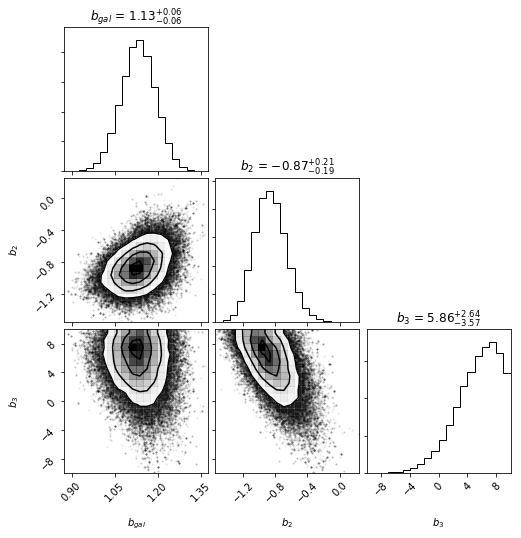

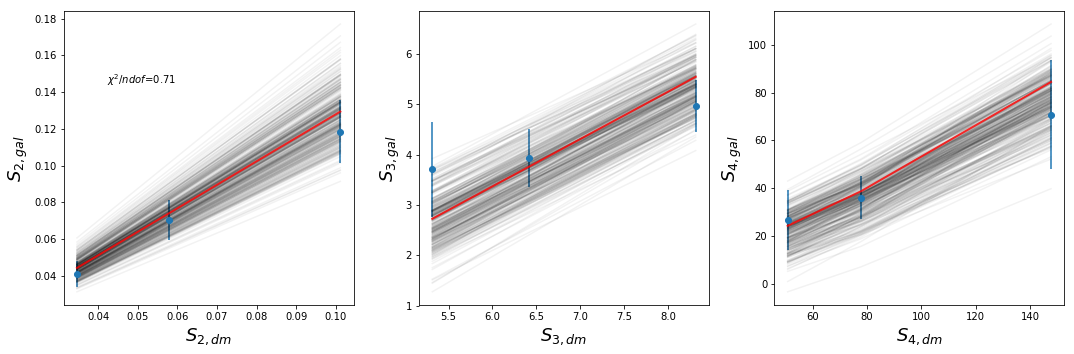

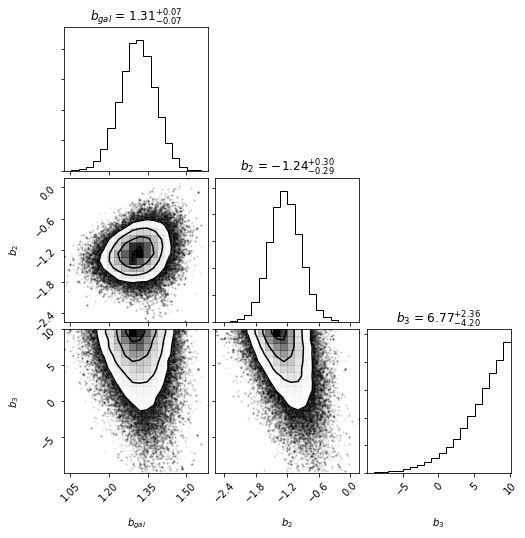

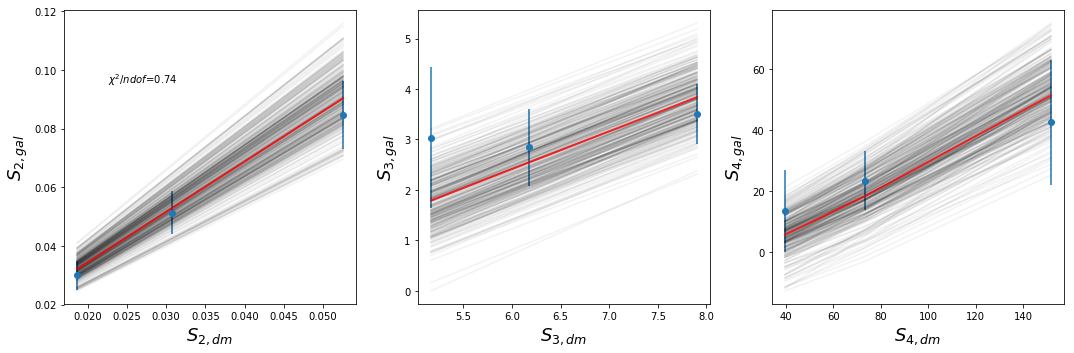

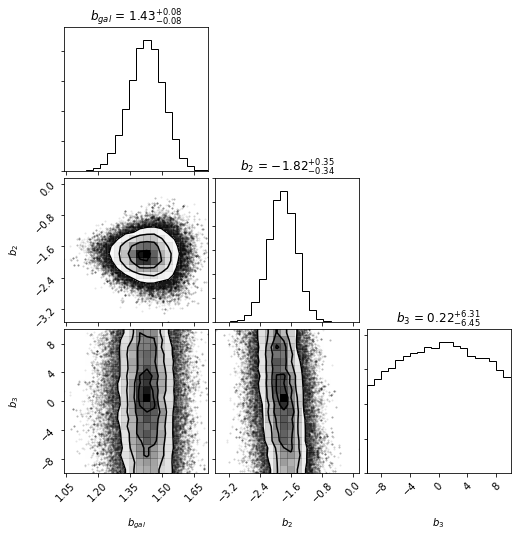

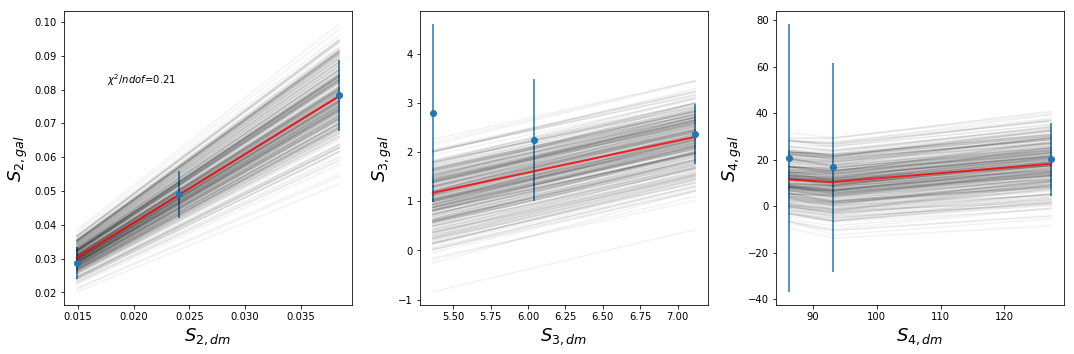

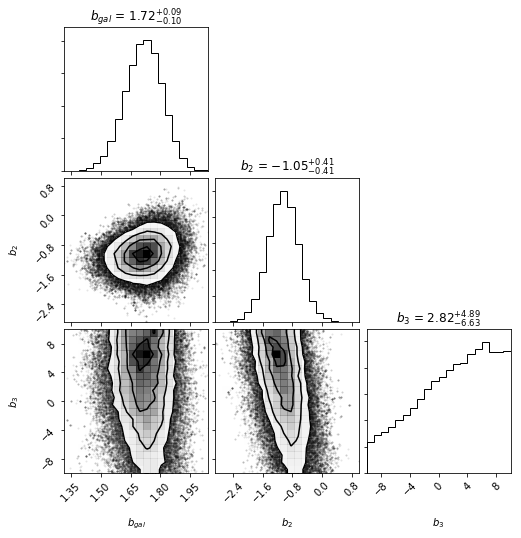

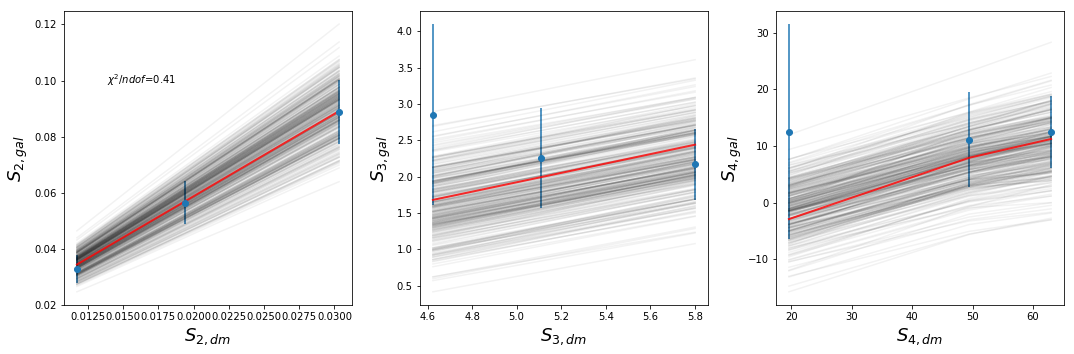

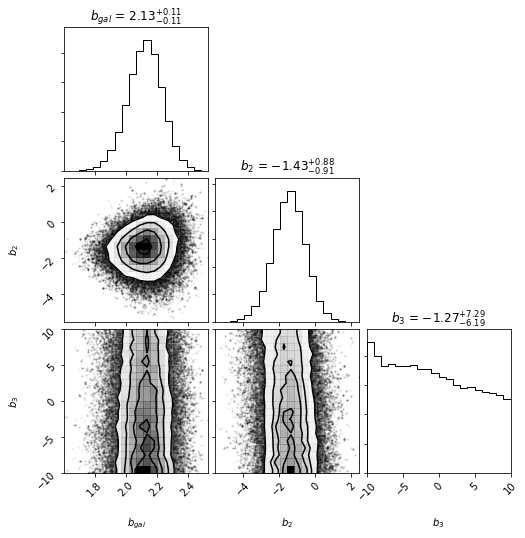

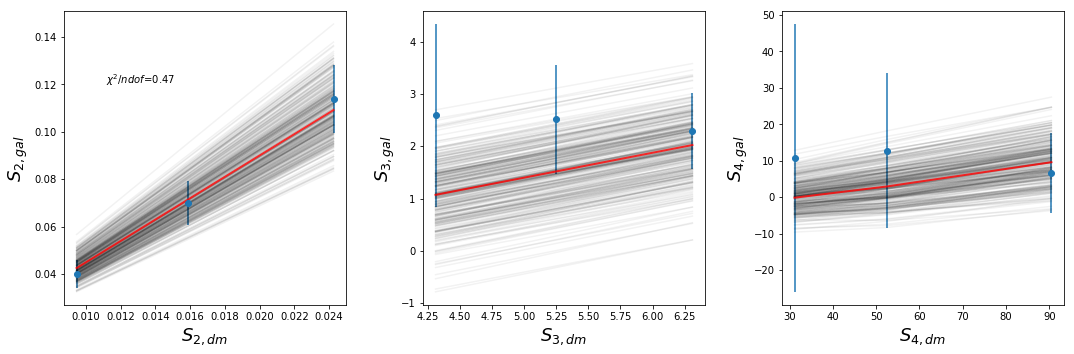

In [17]:
b0_arr = np.zeros(5)
b2_arr = np.zeros(5)
b3_arr = np.zeros(5)
g2_arr = np.zeros(5)
redchi_arr = np.zeros(5)
b0_err_arr = np.zeros(5)
b2_err_arr = np.zeros(5)
b3_err_arr = np.zeros(5)
g2_err_arr = np.zeros(5)
for ibin in range(0,5):
    b0_arr[ibin], b2_arr[ibin], b3_arr[ibin], g2_arr[ibin], b0_err_arr[ibin], b2_err_arr[ibin], b3_err_arr[ibin], g2_err_arr[ibin], redchi_arr[ibin] = fit_nl_bias(ibin,nend=5, nstart=2,st=False,nl=False,dataset='sim')

## Non stochastic, local + non-local

[ 1.11809009 -1.18479104 10.         -0.3707487 ]
[ 1.29931675 -1.34407683 10.          0.0430111 ]
[ 1.41868696 -2.58382703 10.         -0.82168434]
[ 1.70435688 -1.46006908 10.         -0.26689047]
[ 2.11363584 -3.60845835 10.         -1.8716974 ]


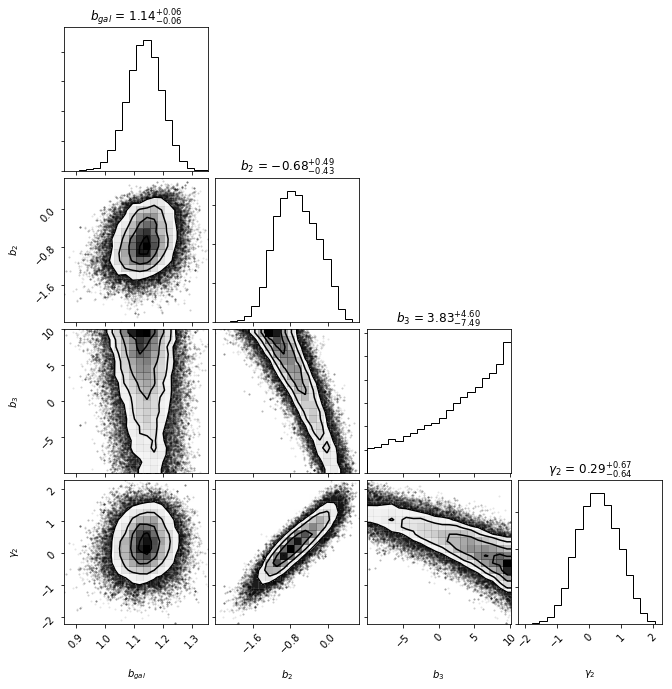

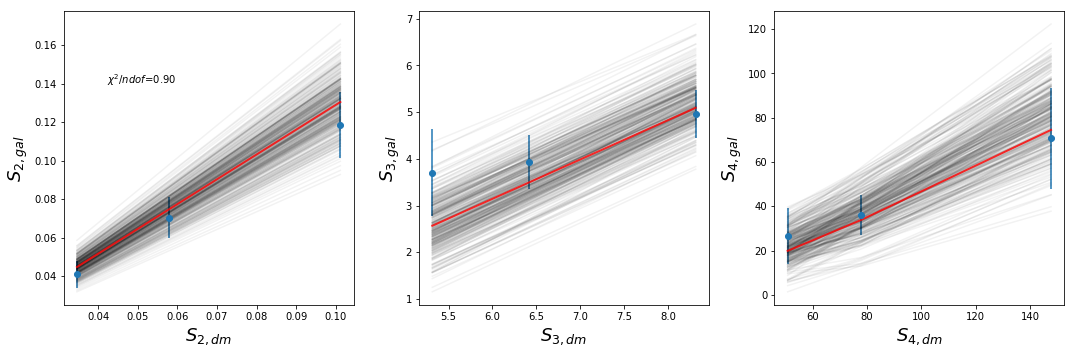

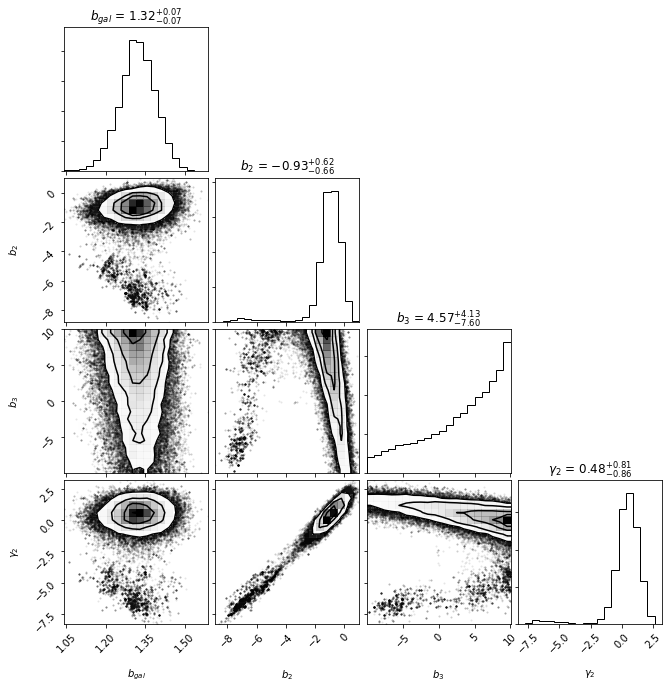

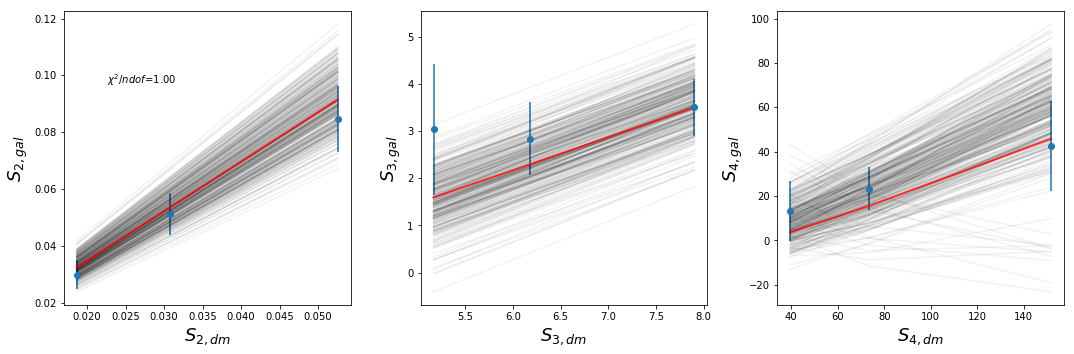

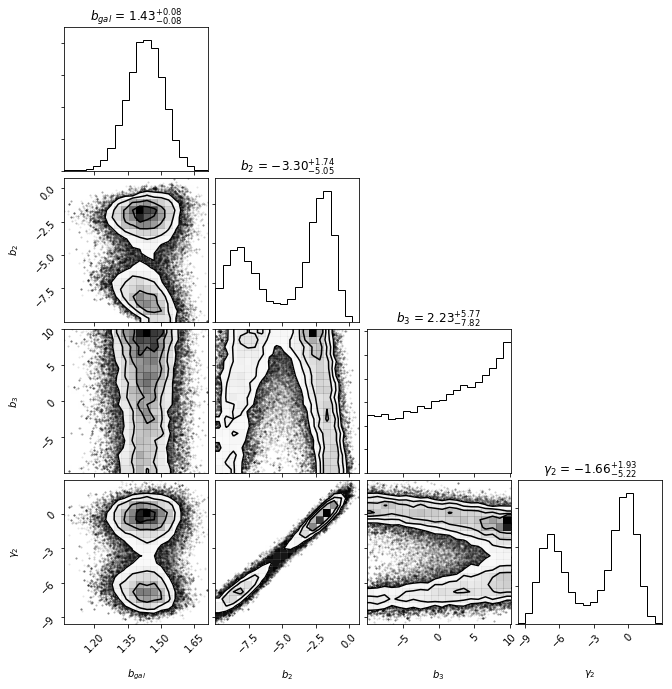

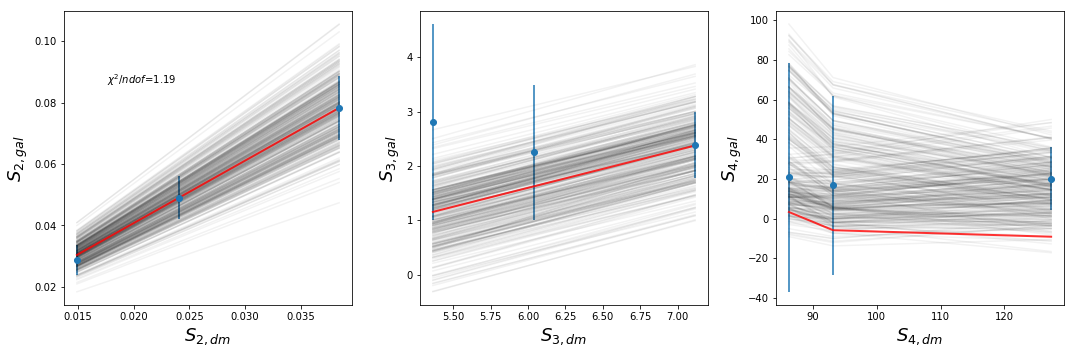

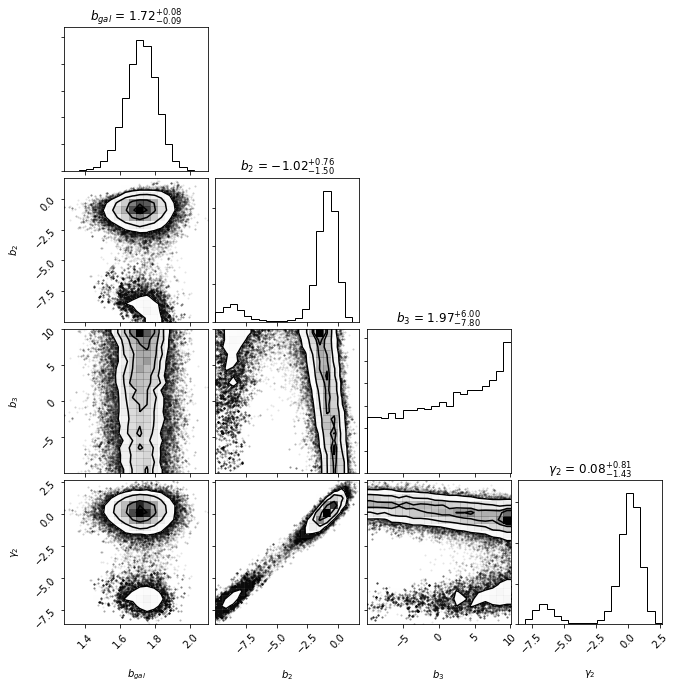

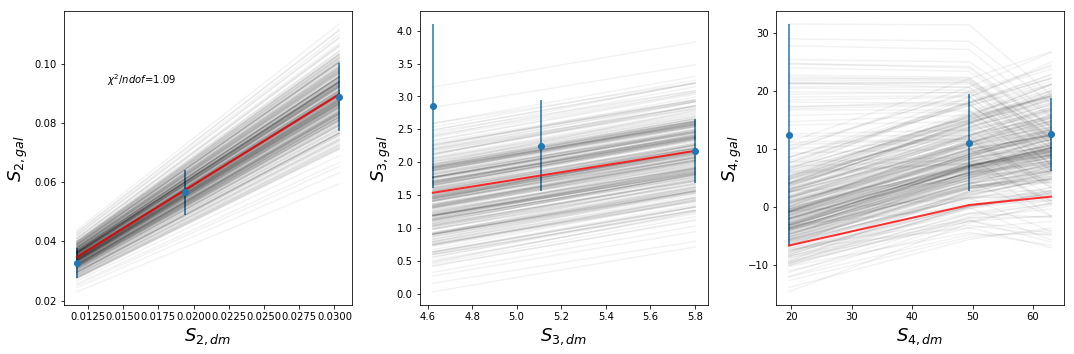

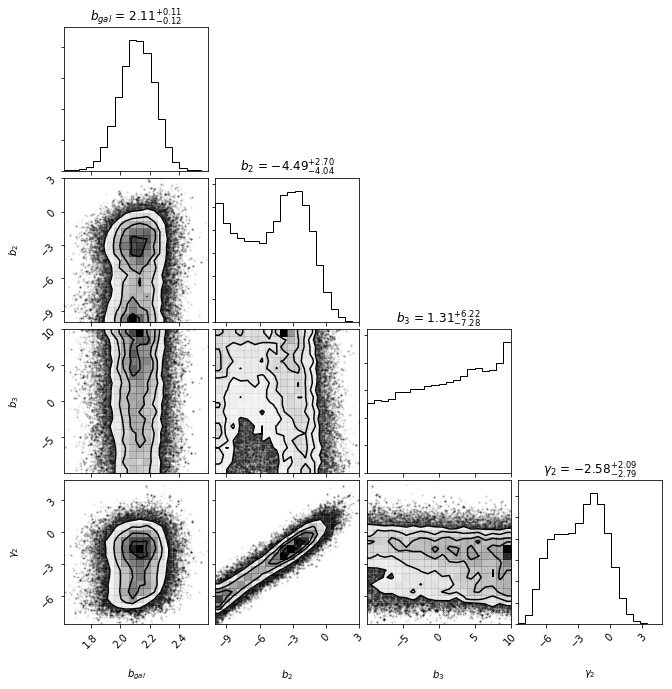

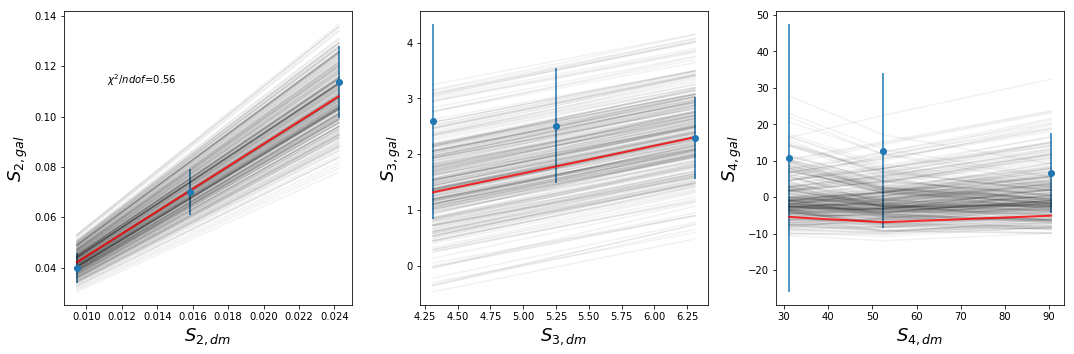

In [33]:
b0_arr2 = np.zeros(5)
b2_arr2 = np.zeros(5)
b3_arr2 = np.zeros(5)
g2_arr2 = np.zeros(5)
redchi_arr2 = np.zeros(5)
b0_err_arr2 = np.zeros(5)
b2_err_arr2 = np.zeros(5)
b3_err_arr2 = np.zeros(5)
g2_err_arr2 = np.zeros(5)
for ibin in range(0,5):
    b0_arr2[ibin], b2_arr2[ibin], b3_arr2[ibin], g2_arr2[ibin], b0_err_arr2[ibin], b2_err_arr2[ibin], b3_err_arr2[ibin], g2_err_arr2[ibin], redchi_arr2[ibin] = fit_nl_bias(ibin,nend=5, nstart=2,st=False,nl=True,dataset='sim')

## Stochastic, local

[ 1.  -0.5  0. ]
[ 1.  -0.5  0. ]


[ 1.  -0.5  0. ]
[ 1.  -0.5  0. ]
[ 1.  -0.5  0. ]


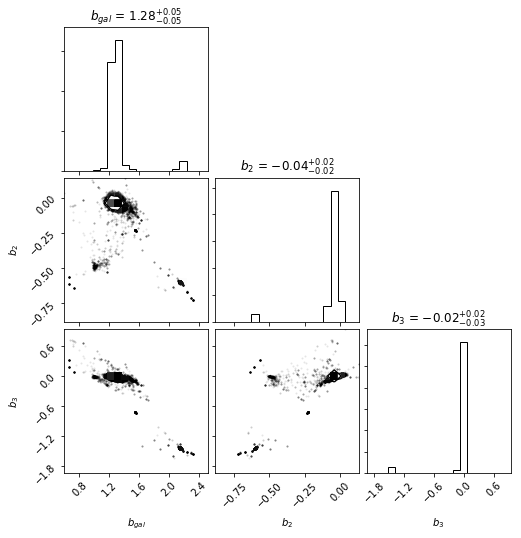

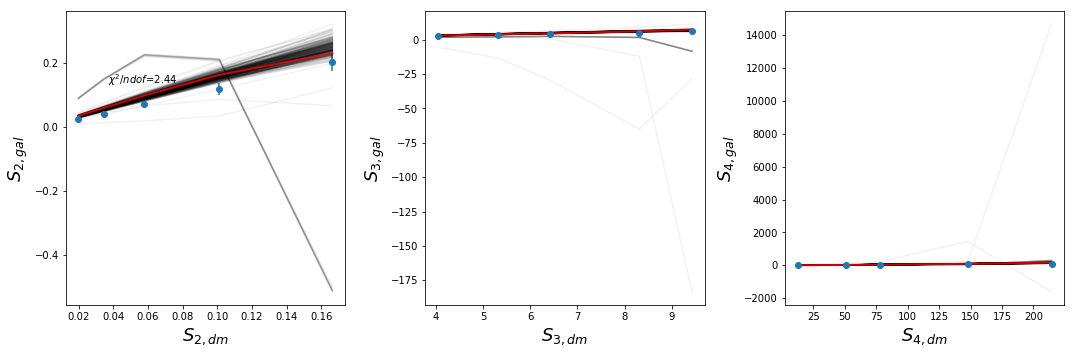

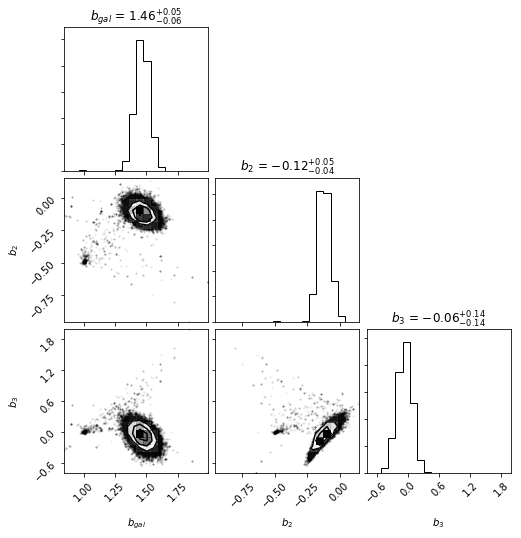

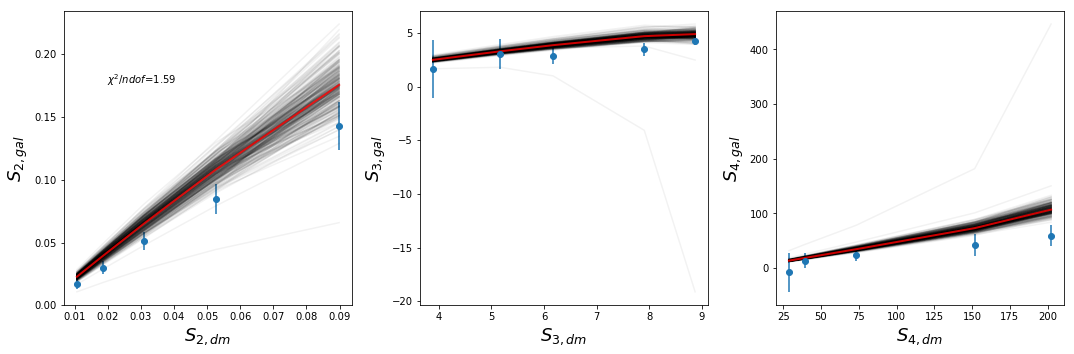

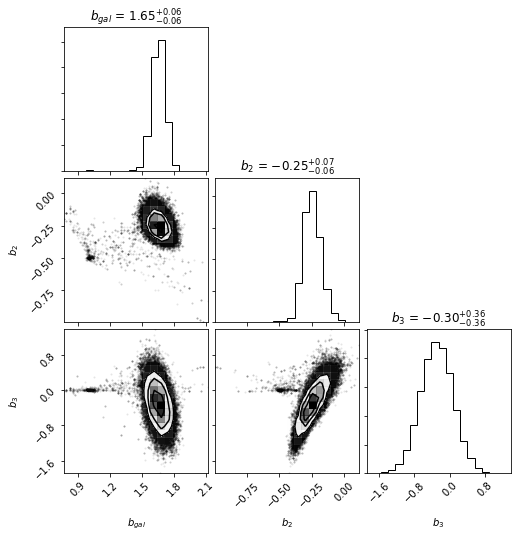

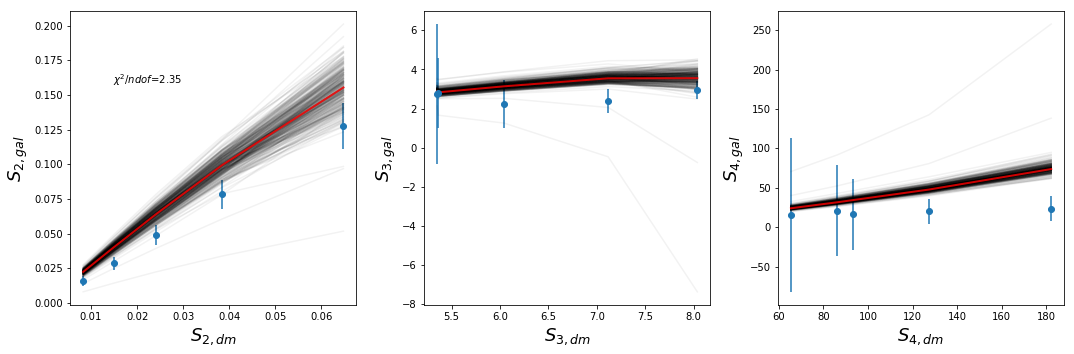

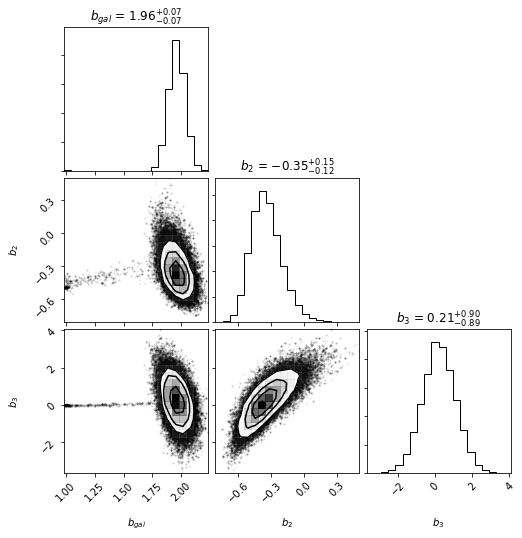

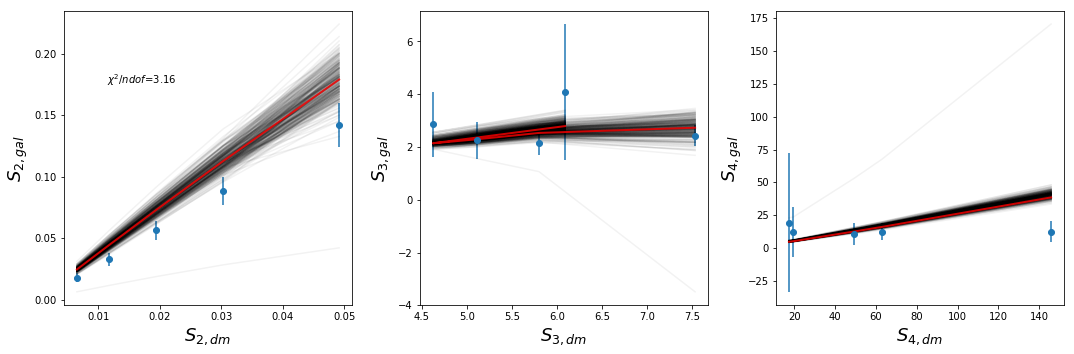

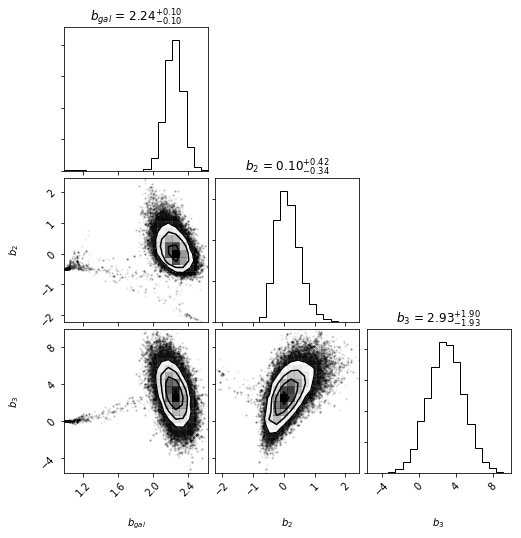

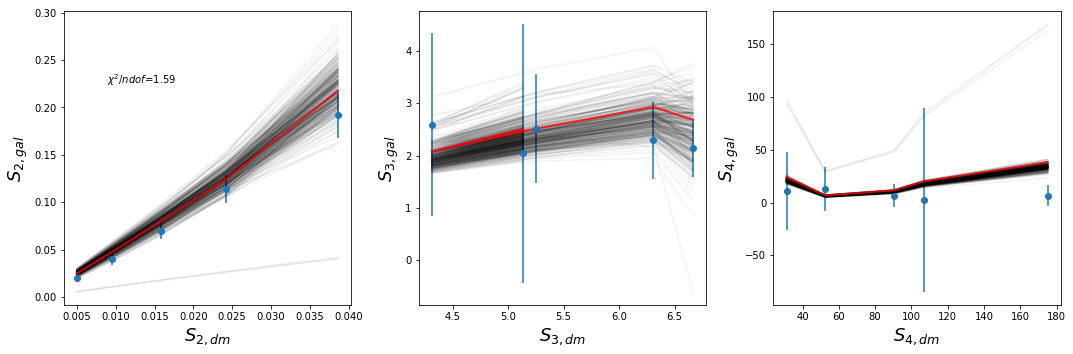

In [19]:
b0_arr3 = np.zeros(5)
b2_arr3 = np.zeros(5)
b3_arr3 = np.zeros(5)
g2_arr3 = np.zeros(5)
redchi_arr3 = np.zeros(5)
b0_err_arr3 = np.zeros(5)
b2_err_arr3 = np.zeros(5)
b3_err_arr3 = np.zeros(5)
g2_err_arr3 = np.zeros(5)
for ibin in range(0,5):
    b0_arr3[ibin], b2_arr3[ibin], b3_arr3[ibin], g2_arr3[ibin], b0_err_arr3[ibin], b2_err_arr3[ibin], b3_err_arr3[ibin], g2_err_arr3[ibin], redchi_arr3[ibin] = fit_nl_bias(ibin,nend=6, nstart=1,st=True,nl=False,dataset='sim')

## Stochastic, non-local

[ 1.  -0.5  0.   0. ]
[ 1.  -0.5  0.   0. ]
[ 1.  -0.5  0.   0. ]
[ 1.  -0.5  0.   0. ]
[ 1.  -0.5  0.   0. ]


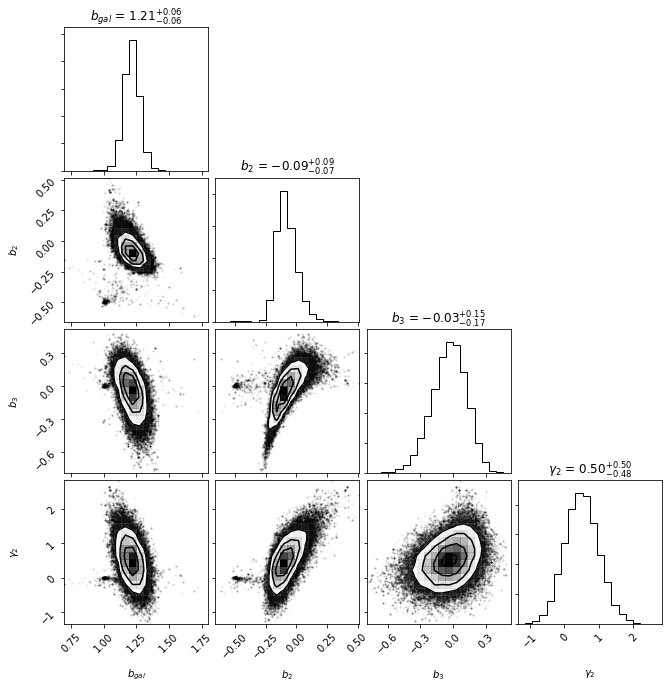

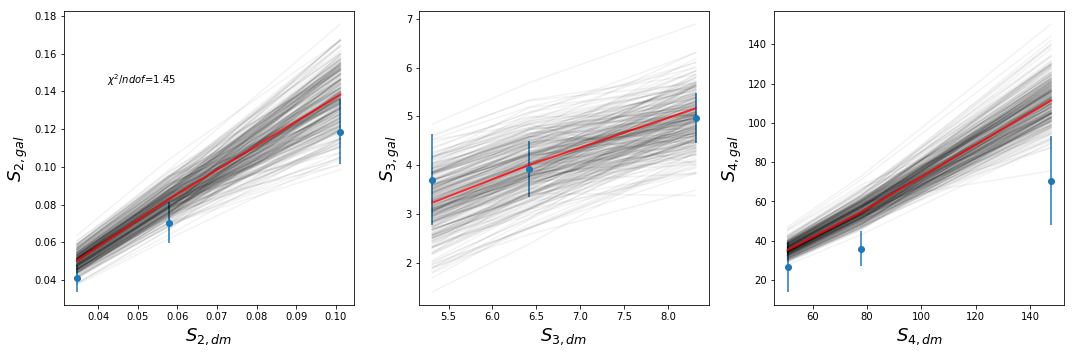

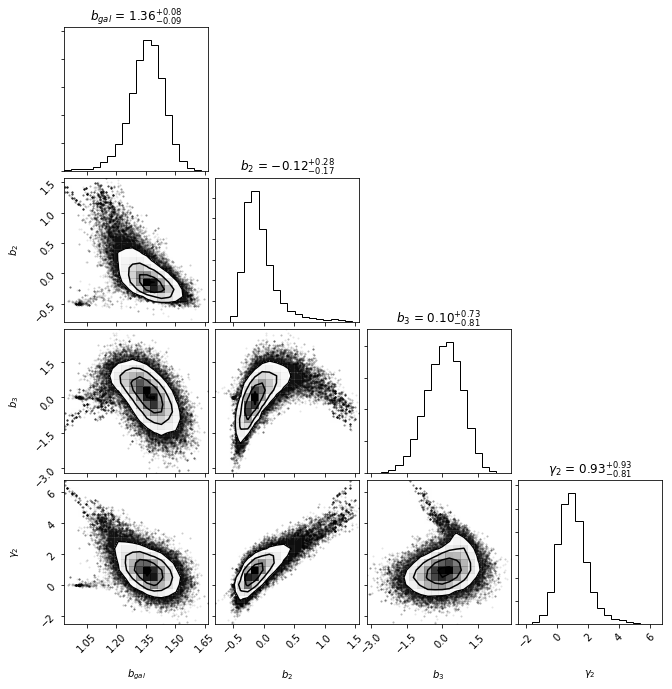

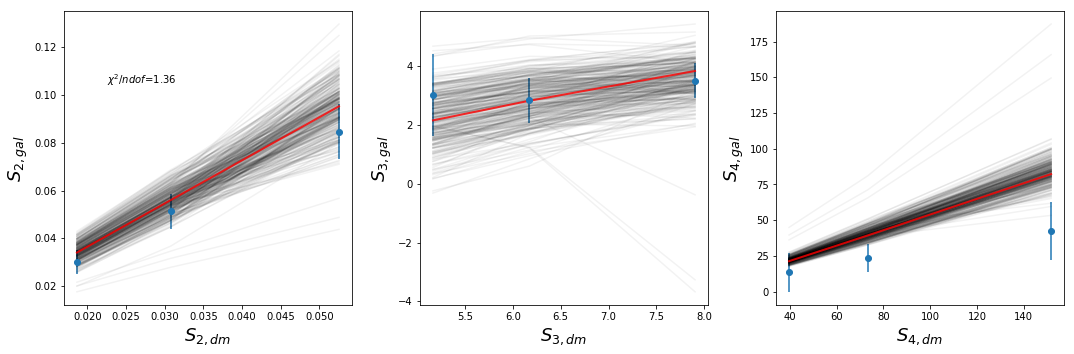

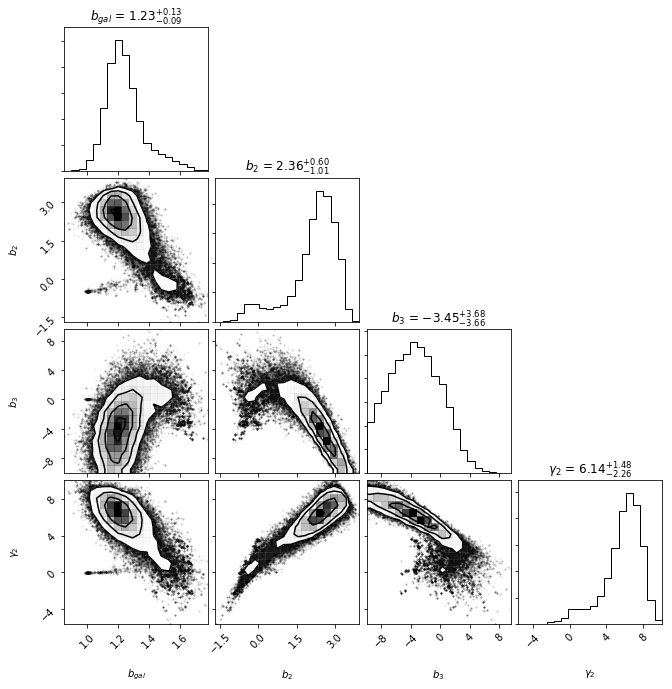

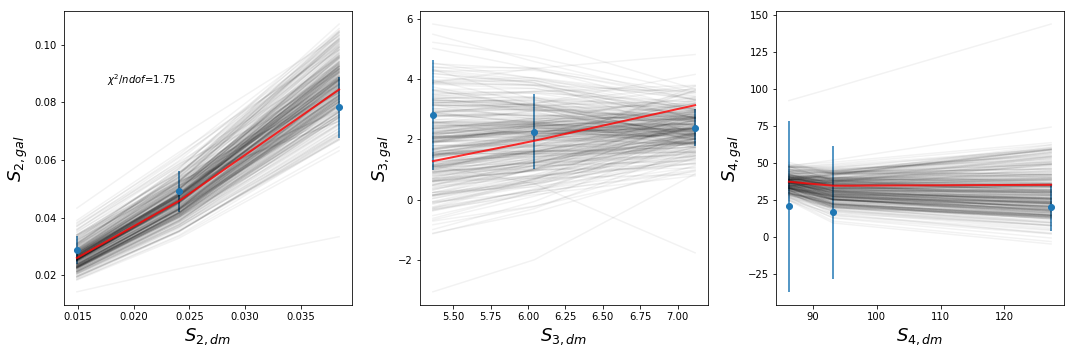

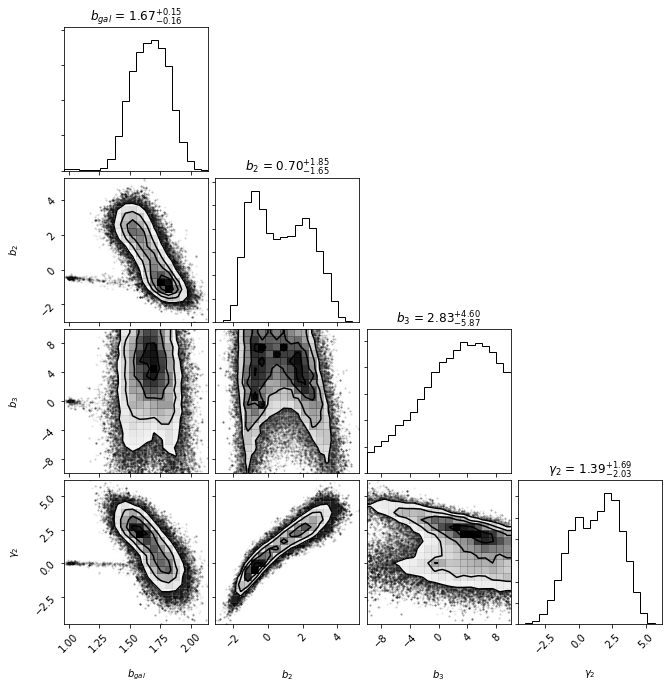

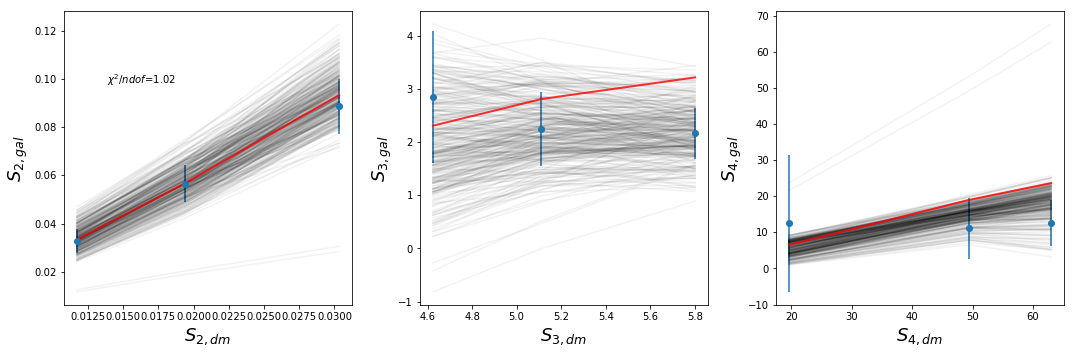

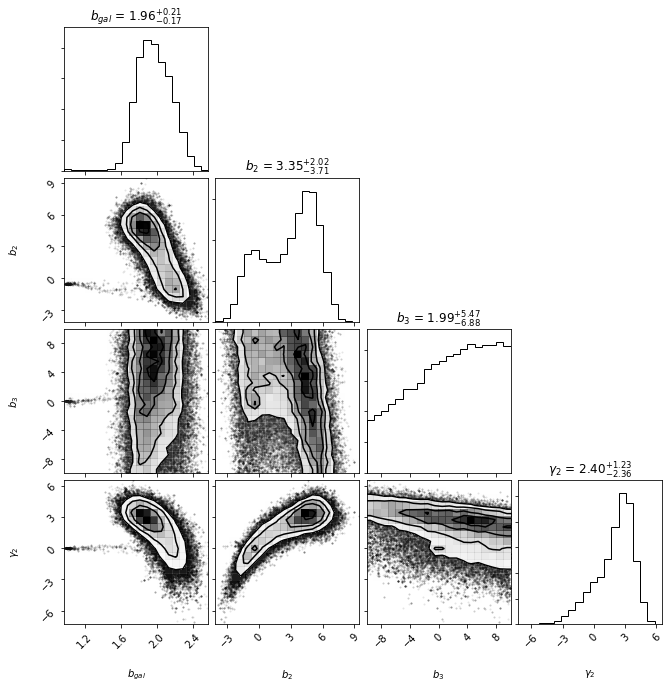

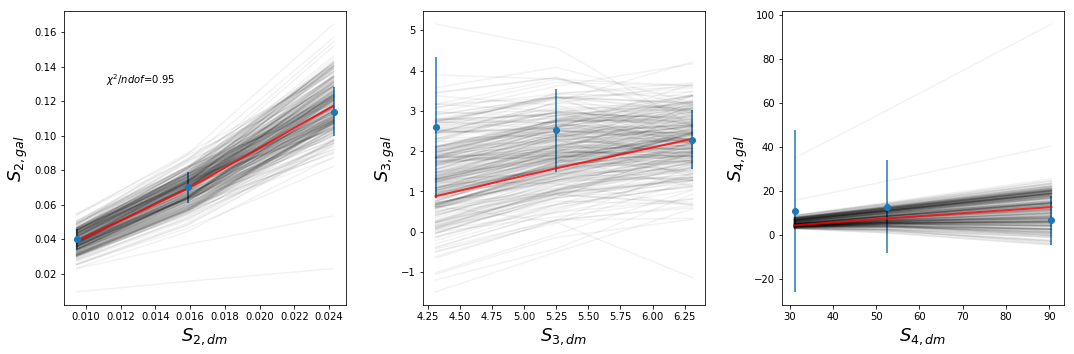

In [34]:
b0_arr4 = np.zeros(5)
b2_arr4 = np.zeros(5)
b3_arr4 = np.zeros(5)
g2_arr4 = np.zeros(5)
redchi_arr4 = np.zeros(5)
b0_err_arr4 = np.zeros(5)
b2_err_arr4 = np.zeros(5)
b3_err_arr4 = np.zeros(5)
g2_err_arr4 = np.zeros(5)
for ibin in range(0,5):
    b0_arr4[ibin], b2_arr4[ibin], b3_arr4[ibin], g2_arr4[ibin], b0_err_arr4[ibin], b2_err_arr4[ibin], b3_err_arr4[ibin], g2_err_arr4[ibin], redchi_arr4[ibin] = fit_nl_bias(ibin,nend=5, nstart=2,st=True,nl=True,dataset='sim')

In [22]:
bias_ang = np.genfromtxt('/Users/javiers/CiC/MICE_ANA_photozgauss/bias_wangular.dat')

In [24]:
z_arr = np.array([0.3,0.5,0.7,0.9,1.1])

In [40]:
import matplotlib as mpl
mpl.style.use('classic')
%matplotlib inline
mpl.rcParams.update({'font.size': 14})

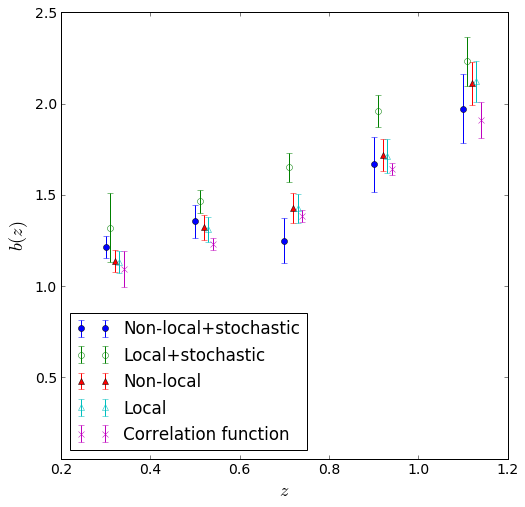

In [44]:
plt.figure(figsize=(8,8))
plt.errorbar(z_arr,b0_arr4,b0_err_arr4,fmt='o',label='Non-local+stochastic')
plt.errorbar(z_arr+0.01,b0_arr3,b0_err_arr3,fmt='o',fillstyle='none',label='Local+stochastic')
plt.errorbar(z_arr+0.02,b0_arr2,b0_err_arr2,fmt='^',label='Non-local')
plt.errorbar(z_arr+0.03,b0_arr,b0_err_arr,fmt='^',fillstyle='none',label='Local')
plt.errorbar(bias_ang[:,0]+0.04,bias_ang[:,1],bias_ang[:,2]*np.sqrt(5000/116.15),fmt='x',label='Correlation function')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize=18)
plt.ylabel('$b(z)$',fontsize=18)
plt.xlim(0.2,1.2)
plt.ylim(0.05,2.5)
plt.savefig('/Users/javiers/CiC/bias_models_comparo_mice.pdf')

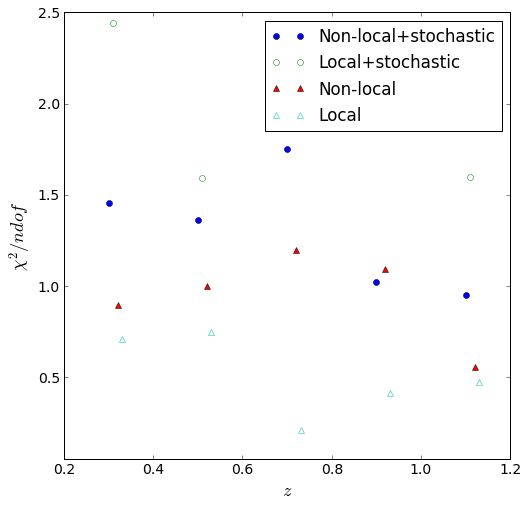

In [45]:
plt.figure(figsize=(8,8))
plt.plot(z_arr,redchi_arr4,'o',label='Non-local+stochastic')
plt.plot(z_arr+0.01,redchi_arr3,'o',fillstyle='none',label='Local+stochastic')
plt.plot(z_arr+0.02,redchi_arr2,'^',label='Non-local')
plt.plot(z_arr+0.03,redchi_arr,'^',fillstyle='none',label='Local')
plt.legend(loc='best')
plt.xlabel('$z$',fontsize=18)
plt.ylabel('$\chi^{2}/ndof$',fontsize=18)
plt.xlim(0.2,1.2)
plt.ylim(0.05,2.5)
plt.savefig('/Users/javiers/CiC/bias_comparo_models_mice_redchi.pdf')